In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import scipy
import h5py
from dnn_utils_v2 import sigmoid, sigmoid_backward, relu, relu_backward
import time
from PIL import Image
from scipy import ndimage

%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 4.0) 
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

np.random.seed(1)

In [2]:
train = h5py.File('train_catvnoncat.h5', "r")
train_x_orig = np.array(train["train_set_x"][:]) 
train_y = np.array(train["train_set_y"][:]) 

test = h5py.File('test_catvnoncat.h5', "r")
test_x_orig = np.array(test["test_set_x"][:]) 
test_y = np.array(test["test_set_y"][:]) 

classes = np.array(test["list_classes"][:]) 
    
train_y = train_y.reshape((1, train_y.shape[0]))
test_y = test_y.reshape((1, test_y.shape[0]))

y = 0. It's a non-cat picture.


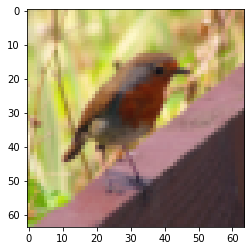

In [3]:
index = 10
plt.imshow(train_x_orig[index])
print ("y = " + str(train_y[0,index]) + ". It's a " + classes[train_y[0,index]].decode("utf-8") +  " picture.")

In [4]:
m_train = train_x_orig.shape[0]
num_px = train_x_orig.shape[1]
m_test = test_x_orig.shape[0]

print ("Number of training examples: " + str(m_train))
print ("Number of testing examples: " + str(m_test))
print ("Each image is of size: (" + str(num_px) + ", " + str(num_px) + ", 3)")
print ("train_x_orig shape: " + str(train_x_orig.shape))
print ("train_y shape: " + str(train_y.shape))
print ("test_x_orig shape: " + str(test_x_orig.shape))
print ("test_y shape: " + str(test_y.shape))

Number of training examples: 209
Number of testing examples: 50
Each image is of size: (64, 64, 3)
train_x_orig shape: (209, 64, 64, 3)
train_y shape: (1, 209)
test_x_orig shape: (50, 64, 64, 3)
test_y shape: (1, 50)


In [5]:
# Reshape the training and test examples 
train_x_flat = train_x_orig.reshape(train_x_orig.shape[0], -1).T   
test_x_flat = test_x_orig.reshape(test_x_orig.shape[0], -1).T

# Standardize data to have feature values between 0 and 1.
train_x = train_x_flat/255.
test_x = test_x_flat/255.

print ("train_x's shape: " + str(train_x.shape))
print ("test_x's shape: " + str(test_x.shape))


train_x's shape: (12288, 209)
test_x's shape: (12288, 50)


## Xavier Initialization

In [6]:
def initialize(layer_dims):
  
    np.random.seed(1)
    parameters = {}
    L = len(layer_dims)            

    for l in range(1, L):
        parameters['W' + str(l)] = np.random.randn(layer_dims[l], layer_dims[l-1]) / np.sqrt(layer_dims[l-1]) 
        parameters['b' + str(l)] = np.zeros((layer_dims[l], 1))
        
    return parameters


In [7]:
def random_mini_batch(X, Y, mini_batch_size, seed):
    np.random.seed(seed)
    minibatches=[]
    m=X.shape[1]
    perm = list(np.random.permutation(m))
    shuffled_X = X[:,perm]
    shuffled_Y = Y[:,perm].reshape(1,m)
    
    num_batch = math.floor(m/mini_batch_size)
    
    for k in range(0,num_batch):
        minibatch_X = shuffled_X[:,k*mini_batch_size: (k+1)*mini_batch_size]
        minibatch_Y = shuffled_Y[:,k*mini_batch_size: (k+1)*mini_batch_size]
        minibatch = (minibatch_X, minibatch_Y)
        minibatches.append(minibatch)
     
    if m%mini_batch_size != 0:
        minibatch_X = shuffled_X[:,num_batch*mini_batch_size:m]
        minibatch_Y = shuffled_Y[:,num_batch*mini_batch_size:m]
        minibatch = (minibatch_X, minibatch_Y)
        minibatches.append(minibatch)
    
    return minibatches
        


## Forward Propogation

In [8]:
def linear_forward(A, W, b):
    Z = W.dot(A) + b
    
    assert(Z.shape == (W.shape[0], A.shape[1]))
    cache = (A, W, b)
    
    return Z, cache

In [9]:
def activation(A_prev, W, b, activation):
   
    if activation == "sigmoid":
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = sigmoid(Z)
    
    elif activation == "relu":
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = relu(Z)
    
    cache = (linear_cache, activation_cache)

    return A, cache

In [10]:
def forward_propogation(X, parameters):
    caches = []
    A = X
    L = len(parameters) // 2                  
    
    for l in range(1, L):
        A_prev = A 
        A, cache = activation(A_prev, parameters['W' + str(l)], parameters['b' + str(l)], activation = "relu")
        caches.append(cache)
    
    AL, cache = activation(A, parameters['W' + str(L)], parameters['b' + str(L)], activation = "sigmoid")
    caches.append(cache)
                
    return AL, caches


## Cost Function

In [11]:
def compute_cost(AL, Y):
   
    m = Y.shape[1]
    cost = (1./m) * (-np.dot(Y,np.log(AL).T) - np.dot(1-Y, np.log(1-AL).T))
    
    cost = np.squeeze(cost)      
     
    return cost

## Back Propogation

In [12]:
def linear_backward(dZ, cache):
    A_prev, W, b = cache
    m = A_prev.shape[1]

    dW = 1./m * np.dot(dZ,A_prev.T)
    db = 1./m * np.sum(dZ, axis = 1, keepdims = True)
    dA_prev = np.dot(W.T,dZ)
    
    return dA_prev, dW, db

In [13]:
def activation_backward(dA, cache, activation):

    linear_cache, activation_cache = cache
    
    if activation == "relu":
        dZ = relu_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache)
        
    elif activation == "sigmoid":
        dZ = sigmoid_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache)
    
    return dA_prev, dW, db

In [14]:
def backward_propogation(AL, Y, caches):

    grads = {}
    L = len(caches) 
    m = AL.shape[1]
    Y = Y.reshape(AL.shape) 
    
    dAL = - (np.divide(Y, AL) - np.divide(1 - Y, 1 - AL))
    
    current_cache = caches[L-1]
    grads["dA" + str(L-1)], grads["dW" + str(L)], grads["db" + str(L)] = activation_backward(dAL, current_cache, activation = "sigmoid")
    
    for l in reversed(range(L-1)):
        current_cache = caches[l]
        dA_prev_temp, dW_temp, db_temp = activation_backward(grads["dA" + str(l + 1)], current_cache, activation = "relu")
        grads["dA" + str(l)] = dA_prev_temp
        grads["dW" + str(l + 1)] = dW_temp
        grads["db" + str(l + 1)] = db_temp

    return grads


## Gradient Descent

In [15]:
def update_parameters_gd(parameters, grads, learning_rate):
    L = len(parameters) // 2 
    
    for l in range(L):
        parameters["W" + str(l+1)] = parameters["W" + str(l+1)] - learning_rate * grads["dW" + str(l+1)]
        parameters["b" + str(l+1)] = parameters["b" + str(l+1)] - learning_rate * grads["db" + str(l+1)]
        
    return parameters

## Adam Optimizer

In [16]:
def initialize_adam(parameters) :
    L = len(parameters) // 2 
    v = {}
    s = {}
    
    for l in range(L):
        v["dW" + str(l+1)] = np.zeros((parameters['W' + str(l+1)].shape[0],parameters['W' + str(l+1)].shape[1]))
        v["db" + str(l+1)] = np.zeros((parameters['b' + str(l+1)].shape[0],parameters['b' + str(l+1)].shape[1]))
        s["dW" + str(l+1)] = np.zeros((parameters['W' + str(l+1)].shape[0],parameters['W' + str(l+1)].shape[1]))
        s["db" + str(l+1)] = np.zeros((parameters['b' + str(l+1)].shape[0],parameters['b' + str(l+1)].shape[1]))    
    return v, s

In [17]:
def update_parameters_adam(parameters, grads, v, s, t, learning_rate = 0.0075,beta1 = 0.9, beta2 = 0.999,  epsilon = 1e-8):
    L = len(parameters) // 2                 
    v_corrected = {}                         
    s_corrected = {}                         
    
    for l in range(L):
        v["dW" + str(l+1)] = beta1*v["dW" + str(l+1)] + (1-beta1)*grads['dW' + str(l+1)]
        v["db" + str(l+1)] = beta1*v["db" + str(l+1)] + (1-beta1)*grads['db' + str(l+1)]
    
        v_corrected["dW" + str(l+1)] = v["dW" + str(l+1)]/(1-(beta1**t))
        v_corrected["db" + str(l+1)] = v["db" + str(l+1)]/(1-(beta1**t))

        s["dW" + str(l+1)] = beta2*s["dW" + str(l+1)] + (1-beta2)*(np.square(grads['dW' + str(l+1)]))
        s["db" + str(l+1)] = beta2*s["db" + str(l+1)] + (1-beta2)*(np.square(grads['db' + str(l+1)]))
 
        s_corrected["dW" + str(l+1)] = s["dW" + str(l+1)]/(1-beta2**t)
        s_corrected["db" + str(l+1)] = s["db" + str(l+1)]/(1-beta2**t)
   
        parameters["W" + str(l+1)] = parameters["W" + str(l+1)] - learning_rate*v_corrected["dW" + str(l+1)]/(np.sqrt(s_corrected["dW" + str(l+1)])+epsilon)
        parameters["b" + str(l+1)] = parameters["b" + str(l+1)] - learning_rate*v_corrected["db" + str(l+1)]/(np.sqrt(s_corrected["db" + str(l+1)])+epsilon)
    return parameters, v, s

In [18]:
def predict(X, y, parameters):
    """
    This function is used to predict the results of a  L-layer neural network.
    
    Arguments:
    X -- data set of examples you would like to label
    parameters -- parameters of the trained model
    
    Returns:
    p -- predictions for the given dataset X
    """
    
    m = X.shape[1]
    n = len(parameters) // 2 
    p = np.zeros((1,m))
    
    probas, caches = forward_propogation(X, parameters)

    for i in range(0, probas.shape[1]):
        if probas[0,i] > 0.5:
            p[0,i] = 1
        else:
            p[0,i] = 0

    print("Accuracy: "  + str(np.sum((p == y)/m)))
        
    return p

In [19]:
def model(X,Y,layers_dims,optimizer,learning_rate=0.0075,mini_batch_size=64, num_epoch=2500, beta1=0.9, beta2=0.999, epsilon=1e-8, print_cost=True):
    seed=10
    costs=[]
    L=len(layers_dims)
    m=X.shape[1]
    t=0
    
    parameters=initialize(layers_dims)
    
    if optimizer == 'gd':
        pass
    elif optimizer == 'adam':
        v, s = initialize_adam(parameters)
    
    for i in range(num_epoch):
        minibatches= random_mini_batch(X,Y,mini_batch_size,seed)
        seed=seed+1
        cost_epoch=0
        for minibatch in minibatches:
            (minibatch_X, minibatch_Y) = minibatch
            
            AL,caches = forward_propogation(minibatch_X,parameters)
            
            cost_epoch += compute_cost(AL, minibatch_Y)
            
            grads = backward_propogation(AL, minibatch_Y, caches)
            
            if optimizer == 'gd':
                parameters = update_parameters_gd(parameters, grads, learning_rate)
            elif optimizer == 'adam':
                t=t+1
                parameters, v, s = update_parameters_adam(parameters, grads, v, s, t, learning_rate, beta1, beta2,  epsilon)
            
        cost_avg = cost_epoch/m
        
        if print_cost and i % 100 == 0:
            print ("Cost after epoch %i: %f" %(i, cost_avg))
        if print_cost and i % 100 == 0:
            costs.append(cost_avg)
            
    # plot the cost
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per hundreds)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    return parameters

In [20]:
layers_dims = [train_x.shape[0],20,7,5, 1]

Cost after epoch 0: 0.013683
Cost after epoch 1000: 0.001126
Cost after epoch 2000: 0.000845


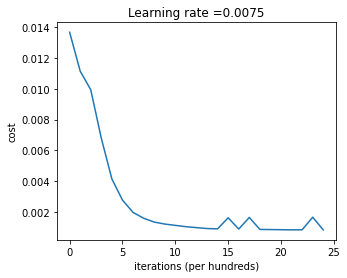

In [21]:
parameters = model(train_x, train_y, layers_dims, optimizer= 'gd', print_cost = True)

In [22]:
pred_train = predict(train_x, train_y, parameters)

Accuracy: 0.9904306220095691


In [23]:
pred_test = predict(test_x, test_y, parameters)

Accuracy: 0.78
